In [216]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


In [217]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.losses import MeanAbsolutePercentageError

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [218]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [219]:
DIR_DATA  = '../input/diploma/'

In [220]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

In [221]:
data_d_help = data_d

# Вспомогательные функции расчета метрик.

In [222]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [223]:
# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [224]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

# Общие сведения, задачи, примерный план работы.

In [225]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Удалено, потому что громоздко.

# Анализ целевой переменной.

In [226]:
data_d.head(10)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,NaN,NaN,PAPH847006,"$209,000"
6,Active,NaN,Florida,552 Casanova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","1,507",34759,NaN,FL,One,NaN,NaN,S5026943,"181,500"
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,"68,000"
8,Active,NaN,Single Family Home,11182 Owl Ave,2,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588,50401,3,IA,NaN,NaN,NaN,190988,"$244,900"
9,NaN,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",77080,3,TX,2.0,NaN,NaN,73968331,"$311,995"


# Вспомогательная функция извлечения числа из записи доллара.

In [227]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return np.NaN
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return float(dollar_res)


In [228]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [229]:
data_d['target'].isna().unique()

array([False,  True])

In [230]:
data_d['target'].value_counts()

225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
325000.0    1562
            ... 
236070.0       1
752911.0       1
73360.0        1
455740.0       1
171306.0       1
Name: target, Length: 34232, dtype: int64

In [231]:
data_d['target'].fillna(value = data_d.target.median(), inplace = True)

In [232]:
data_d['target'].isna().unique()

array([False])

<AxesSubplot:xlabel='target', ylabel='Density'>

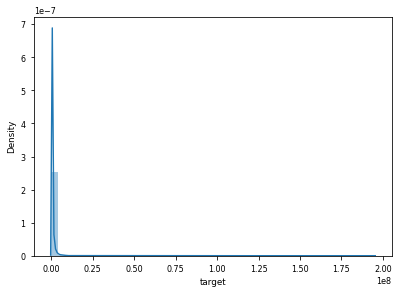

In [233]:
sns.distplot(data_d['target'])

Предварительное грубое удаление выбросов.

In [234]:
data_d.loc[data_d['target'].median()]

status                                                     Active
private pool                                                  NaN
propertyType                        Condo/Townhome/Row Home/Co-Op
street                              1080 Wisconsin Ave NW Apt 304
baths                                                         1.5
homeFacts       {'atAGlanceFacts': [{'factValue': '1981', 'fac...
fireplace                                                     NaN
city                                                   Washington
schools         [{'rating': ['8', '8', '8', '8', '9', '9', 'NR...
sqft                                                          946
zipcode                                                     20007
beds                                                            1
state                                                          DC
stories                                                        3+
mls-id                                                        NaN
PrivatePoo

In [235]:
data_d['target'].mean()

642621.3540146082

In [236]:
data_d.loc[data_d['target']>data_d['target'].mean()]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,2395000.0
10,for sale,NaN,coop,14205 Roosevelt Ave #512,2 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Flushing,"[{'rating': ['2/10', '8/10', '10/10'], 'data':...","1,300 sqft",11354,3 Beds,NY,NaN,NaN,NaN,3087630,669000.0
15,New,NaN,2 Story,930 52nd St,NaN,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,1650000.0
17,Active,NaN,Townhouse,24 W 126th St,NaN,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,New York,"[{'rating': ['2', '5', '1', '2'], 'data': {'Di...","3,325",10027,NaN,NY,NaN,NaN,NaN,4975368,2650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377168,for sale,NaN,single-family home,24080 Tuscany Ct,5 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Bonita Springs,"[{'rating': ['3/10', '8/10', '4/10', '5/10', '...","5,992 sqft",34134,4 Beds,FL,NaN,NaN,yes,219077435,2495000.0
377174,for sale,NaN,single-family home,1107 E Euclid Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,San Antonio,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950 sqft,78212,2 Beds,TX,1.0,NaN,yes,1391618,799500.0
377179,For sale,NaN,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",20001,2,DC,3.0,NaN,NaN,DCDC444306,799000.0
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,1249000.0


In [237]:
data_d = data_d[(data_d['target'] < 550000)]

<AxesSubplot:xlabel='target', ylabel='Density'>

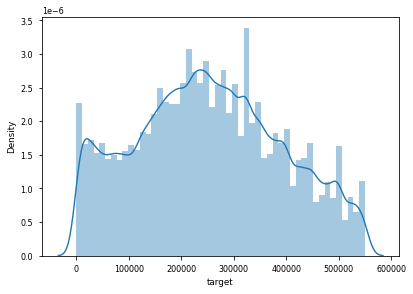

In [238]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f0d9a2ced10>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f0d9a30bf90>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f0d9a2ceb10>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f0d9a2c09d0>}

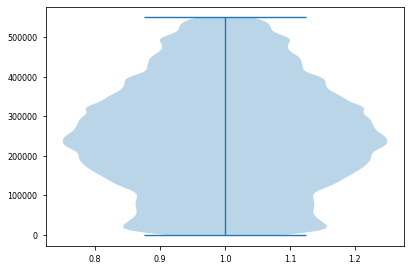

In [239]:
plt.violinplot(data_d['target'])

In [240]:
data_d['target'].isna().unique()

array([False])

In [241]:
data_d.loc[data_d['target']==0]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


In [242]:
data_d.loc[data_d['target'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                   1,947 sqft
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

In [243]:
#data_d.target = np.log(data_d.target[data_d.target > 0])

In [244]:
#data_d['target'].isna().unique()

# Площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, возвращает NaN.

In [245]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return np.NaN
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [246]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

In [247]:
data_d['sqft'].value_counts()

0.0        10652
1200.0      1232
1000.0       906
1100.0       798
1500.0       769
           ...  
8754.0         1
64.0           1
6223.0         1
46996.0        1
7644.0         1
Name: sqft, Length: 5854, dtype: int64

Вместо нулевых значений подставляю нан для упрощения последующей замены.

In [248]:
data_d.sqft = data_d.sqft.apply(lambda x: np.NaN if x==0.0 else x)

In [249]:
data_d['sqft'].value_counts()

1200.0     1232
1000.0      906
1100.0      798
1500.0      769
1400.0      749
           ... 
8754.0        1
64.0          1
6223.0        1
46996.0       1
7644.0        1
Name: sqft, Length: 5853, dtype: int64

In [250]:
data_d['sqft'].unique()

array([2.90000000e+03, 1.94700000e+03,            nan, ...,
       7.20000000e+01, 4.56602479e+08, 7.64400000e+03])

In [251]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276948 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        246827 non-null  object 
 1   private pool  2742 non-null    object 
 2   propertyType  253129 non-null  object 
 3   street        276947 non-null  object 
 4   baths         194069 non-null  object 
 5   homeFacts     276948 non-null  object 
 6   fireplace     67586 non-null   object 
 7   city          276928 non-null  object 
 8   schools       276948 non-null  object 
 9   sqft          235646 non-null  float64
 10  zipcode       276948 non-null  object 
 11  beds          207050 non-null  object 
 12  state         276948 non-null  object 
 13  stories       169302 non-null  object 
 14  mls-id        19149 non-null   object 
 15  PrivatePool   22749 non-null   object 
 16  MlsId         224599 non-null  object 
 17  target        276948 non-null  float64
dtypes: f

In [252]:
data_d.loc[data_d['sqft'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                       1947.0
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

# Спальни - приведение к численному виду.

In [253]:
data_d['beds'].value_counts()

3 Beds        42890
4 Beds        24758
3             24356
2 Beds        20440
4             12920
              ...  
40 acres          1
6.53 acres        1
9,291 sqft        1
6,115 sqft        1
8,479 sqft        1
Name: beds, Length: 959, dtype: int64

In [254]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor')[0])

In [255]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
364340,A Active,NaN,Land,4500 Harris Hill Rd,NaN,"{'atAGlanceFacts': [{'factValue': '1922', 'fac...",NaN,Falconer,"[{'rating': ['5', '5', 'NR', 'NR', 'NR'], 'dat...",1596.0,14733,# Bedrooms 1st Floor,NY,NaN,NaN,NaN,R1171774,79000.0


Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [256]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [257]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [258]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor'))
data_d.beds = data_d.beds.apply(lambda x: 1 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('sqft')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('acres')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('# Bedrooms 1st Floor')>-1) else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

1                                                                         157719
3 Beds                                                                     42890
4 Beds                                                                     24758
2 Beds                                                                     20440
3 bd                                                                       11138
4 bd                                                                        6106
5 Beds                                                                      4814
2 bd                                                                        4650
5 bd                                                                        1317
6 Beds                                                                      1142
1 bd                                                                         982
6 bd                                                                         266
7 Beds                      

In [259]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


Вспомогательная функция для выбора числового значения признака спальни.

In [260]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [261]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [262]:
data_d['beds'].unique()                        


array([ 1,  3,  2,  4,  5,  6,  8,  7, 10, 64, 24,  9, 11, 16, 18, 12, 44,
       17, 14, 13, 15, 28, 20])

In [263]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276948 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        246827 non-null  object 
 1   private pool  2742 non-null    object 
 2   propertyType  253129 non-null  object 
 3   street        276947 non-null  object 
 4   baths         194069 non-null  object 
 5   homeFacts     276948 non-null  object 
 6   fireplace     67586 non-null   object 
 7   city          276928 non-null  object 
 8   schools       276948 non-null  object 
 9   sqft          235646 non-null  float64
 10  zipcode       276948 non-null  object 
 11  beds          276948 non-null  int64  
 12  state         276948 non-null  object 
 13  stories       169302 non-null  object 
 14  mls-id        19149 non-null   object 
 15  PrivatePool   22749 non-null   object 
 16  MlsId         224599 non-null  object 
 17  target        276948 non-null  float64
dtypes: f

# Визуализация и обработка признака спальни (beds).

<AxesSubplot:xlabel='beds', ylabel='Density'>

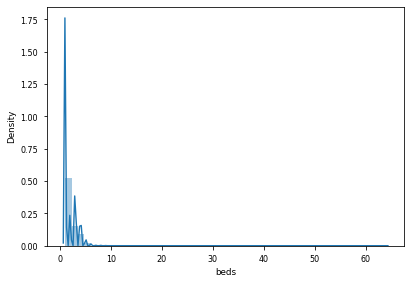

In [264]:
sns.distplot(data_d['beds'])

In [265]:
t = data_d.loc[data_d['beds']>10]

In [266]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 6317 to 370966
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   status        99 non-null     object 
 1   private pool  0 non-null      object 
 2   propertyType  99 non-null     object 
 3   street        99 non-null     object 
 4   baths         43 non-null     object 
 5   homeFacts     99 non-null     object 
 6   fireplace     7 non-null      object 
 7   city          99 non-null     object 
 8   schools       99 non-null     object 
 9   sqft          47 non-null     float64
 10  zipcode       99 non-null     object 
 11  beds          99 non-null     int64  
 12  state         99 non-null     object 
 13  stories       21 non-null     object 
 14  mls-id        9 non-null      object 
 15  PrivatePool   1 non-null      object 
 16  MlsId         86 non-null     object 
 17  target        99 non-null     float64
dtypes: float64(2), int64(1), 

In [267]:
data_d = data_d[(data_d['beds'] < 10)]

<AxesSubplot:xlabel='beds', ylabel='Density'>

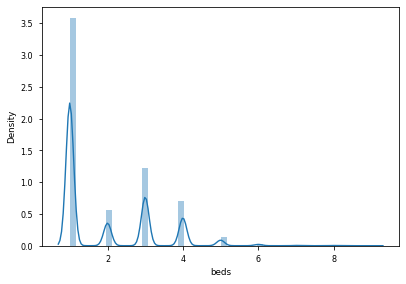

In [268]:
sns.distplot(data_d['beds'])

In [269]:
y = data_d['target']

In [270]:
x = data_d['beds']

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

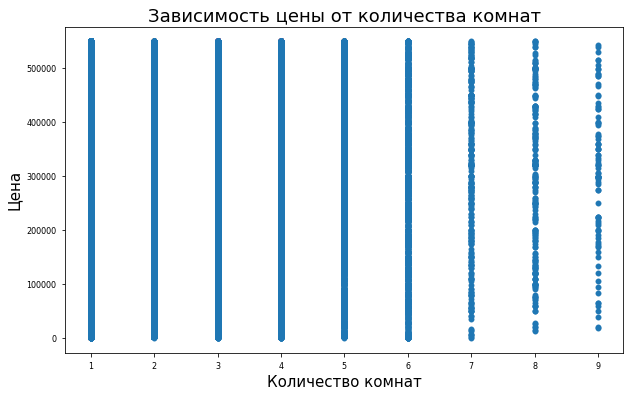

In [271]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)


In [272]:
#data_d.plot(y='target',x='beds', kind='line',
#           color='blue',  title='Зависимость цены от города')

<AxesSubplot:xlabel='beds'>

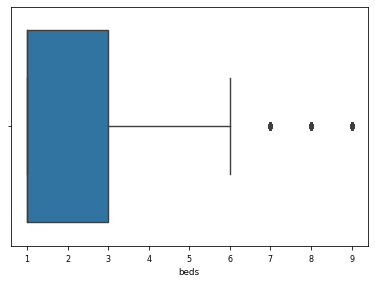

In [273]:
sns.boxplot(data_d['beds'])

# Заполнение пропусков признака площадь по количеству комнат (примерное)

In [274]:
data_d['sqft'].fillna(data_d.groupby('beds')['sqft'].transform('mean'), inplace = True)

In [275]:
data_d.head(30)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.000000,28387,1,NC,NaN,NaN,NaN,611019,418000.0
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.000000,99216,3,WA,2.0,NaN,NaN,201916904,310000.0
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",6594.616652,32908,1,FL,NaN,NaN,NaN,861745,5000.0
5,for sale,NaN,townhouse,1624 S Newkirk St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897.000000,19145,2,PA,2.0,NaN,NaN,PAPH847006,209000.0
6,Active,NaN,Florida,552 Casanova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,POINCIANA,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...",1507.000000,34759,1,FL,One,NaN,NaN,S5026943,181500.0
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",6594.616652,38115,1,TN,NaN,NaN,NaN,10063506,68000.0
8,Active,NaN,Single Family Home,11182 Owl Ave,2,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",NaN,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588.000000,50401,1,IA,NaN,NaN,NaN,190988,244900.0
9,NaN,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...",1930.000000,77080,1,TX,2.0,NaN,NaN,73968331,311995.0
11,Active,NaN,English,4222 False Cypress Ln,NaN,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Houston,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...",3130.000000,77068,1,TX,2,NaN,NaN,5741322,260000.0
12,for sale,NaN,single-family home,16373 NW 16th St,3 Baths,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Pembroke Pines,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...",2839.000000,33028,4,FL,1.0,NaN,yes,A10767242,525000.0


In [276]:
data_d['sqft'].unique()  

array([2.90000000e+03, 1.94700000e+03, 6.59461665e+03, ...,
       7.20000000e+01, 4.56602479e+08, 7.64400000e+03])

In [277]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276803 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        246682 non-null  object 
 1   private pool  2742 non-null    object 
 2   propertyType  252984 non-null  object 
 3   street        276802 non-null  object 
 4   baths         193984 non-null  object 
 5   homeFacts     276803 non-null  object 
 6   fireplace     67573 non-null   object 
 7   city          276783 non-null  object 
 8   schools       276803 non-null  object 
 9   sqft          276803 non-null  float64
 10  zipcode       276803 non-null  object 
 11  beds          276803 non-null  int64  
 12  state         276803 non-null  object 
 13  stories       169266 non-null  object 
 14  mls-id        19133 non-null   object 
 15  PrivatePool   22747 non-null   object 
 16  MlsId         224478 non-null  object 
 17  target        276803 non-null  float64
dtypes: f

# Визуализация признака площадь (sqft).

<AxesSubplot:xlabel='sqft', ylabel='Density'>

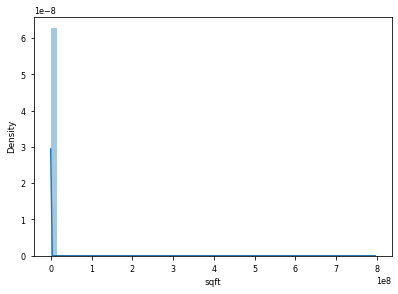

In [278]:
sns.distplot(data_d['sqft'])

In [279]:
data_d = data_d[(data_d['sqft'] < 10000)]

<AxesSubplot:xlabel='sqft', ylabel='Density'>

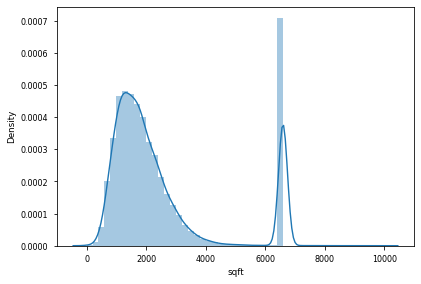

In [280]:

sns.distplot(data_d['sqft'])


In [281]:
x = data_d['sqft']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от площади')

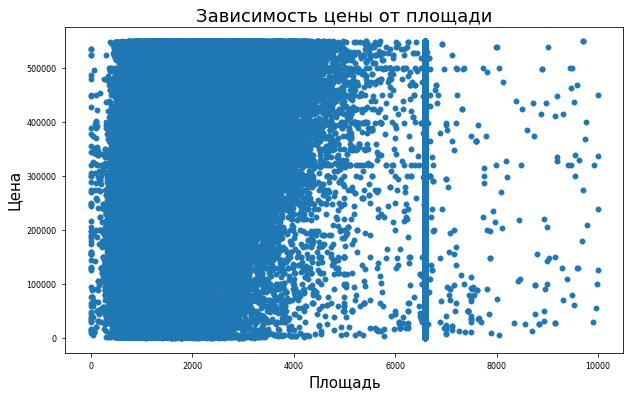

In [282]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

<AxesSubplot:xlabel='sqft'>

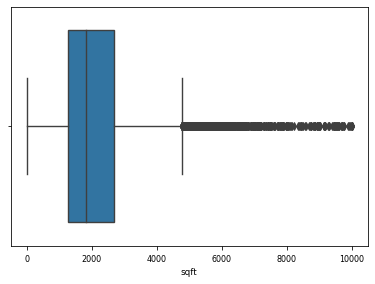

In [283]:
sns.boxplot(data_d['sqft'])

# Ванны - приведение к численному виду.

In [284]:
data_d['baths'].unique()   

array(['3.5', '3 Baths', nan, '2', '3', 'Bathrooms: 2', '1,750',
       '4 Baths', '2 ba', '2 Baths', '2.0', '3.0', 'Bathrooms: 1',
       '2.1 Baths', '2.5 Baths', '1', '4.5', 'Bathrooms: 4', '3 ba',
       '4.0', '2,500', '5.5 Baths', '1.0', 'Bathrooms: 3', '1.5', '2.5',
       '4,000', '3.5 Baths', '2,000', '1 ba', '3.5 ba', '0', '1,500',
       '2,250', '1,000', '3,500', '4', '~', '3,000', '2,750', '750',
       '5 Baths', '1.5 ba', '1,250', '1.5 Baths', '6 Baths', '0 / 0',
       '5 ba', '4 ba', '2.5+', '6.0', '4.5 Baths', '-- baths', '7',
       '1.5+', '6', '5,000', '5', '1.1 Baths', 'Bathrooms: 5', '5.5',
       '19 Baths', '1.75 Baths', 'Bathrooms: 6', '13 Baths', '5.0',
       'Sq. Ft. ', '2.5 ba', '3.5+', '7 Baths', 'Bathrooms: 241', '8.0',
       '6.5', 'Bathrooms: 7', '7,500+', '4.5+', '6.5 Baths', '8 Baths',
       '1.75 ba', '0.00', '2.25 Baths', '3.1 Baths', '4.5 ba',
       '2.75 Baths', '0.0', '10', '16 Baths', '7.0', '20.0',
       'Bathrooms: 8', '2 baths', '15 Bath

Вспомогательная функция извлекает численное значение из текста. Если значение некорректно, выдает 1. Применила здесь, а также для обработки этажей.)

In [285]:
def extract_num_recurr(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 1
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num(stroka,len_s,i+1)

def main_extract_num(stroka):   
    len_s=len(stroka)-1
    
    return extract_num(stroka,len_s,0)

In [286]:
data_d.baths = data_d.baths.apply(lambda x: main_extract_num(str(x)))

In [287]:
data_d['baths'].unique()   

array([3.50e+00, 3.00e+00, 1.00e+00, 2.00e+00, 4.00e+00, 2.10e+00,
       2.50e+00, 4.50e+00, 5.50e+00, 1.50e+00, 0.00e+00, 7.50e+02,
       5.00e+00, 6.00e+00, 7.00e+00, 1.10e+00, 1.90e+01, 1.75e+00,
       1.30e+01, 2.41e+02, 8.00e+00, 6.50e+00, 2.25e+00, 3.10e+00,
       2.75e+00, 1.00e+01, 1.60e+01, 2.00e+01, 1.50e+01, 1.10e+01,
       3.25e+00, 3.75e+00, 3.30e+00, 9.00e+00, 1.25e+00, 2.20e+00,
       1.40e+01, 2.50e+01, 5.00e-01, 1.80e+00, 8.50e+00, 1.20e+01,
       2.80e+00, 3.00e+01, 7.50e-01, 4.10e+00])

In [288]:
data_d['baths'].isna().unique()   

array([False])

# Визуализация и обработка признака ванны (baths).

<AxesSubplot:xlabel='baths', ylabel='Density'>

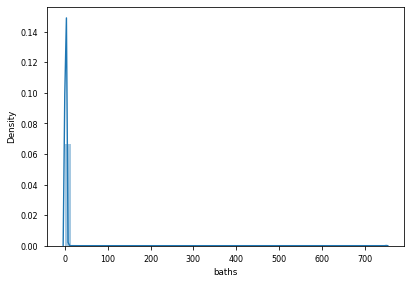

In [289]:
sns.distplot(data_d['baths'])

In [290]:
t = data_d.loc[data_d['baths']>10]

In [291]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 1109 to 376147
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   status        170 non-null    object 
 1   private pool  0 non-null      object 
 2   propertyType  149 non-null    object 
 3   street        173 non-null    object 
 4   baths         173 non-null    float64
 5   homeFacts     173 non-null    object 
 6   fireplace     46 non-null     object 
 7   city          173 non-null    object 
 8   schools       173 non-null    object 
 9   sqft          173 non-null    float64
 10  zipcode       173 non-null    object 
 11  beds          173 non-null    int64  
 12  state         173 non-null    object 
 13  stories       59 non-null     object 
 14  mls-id        3 non-null      object 
 15  PrivatePool   1 non-null      object 
 16  MlsId         166 non-null    object 
 17  target        173 non-null    float64
dtypes: float64(3), int64(1),

In [292]:
data_d = data_d[data_d['baths']<10]

<AxesSubplot:xlabel='baths', ylabel='Density'>

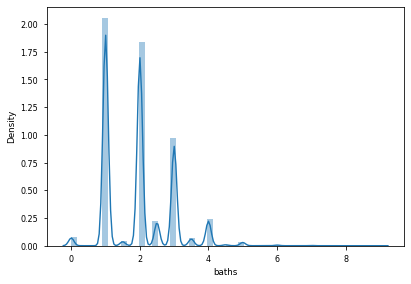

In [293]:
sns.distplot(data_d['baths'])

In [294]:
x = data_d['baths']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от оборудования ванн')

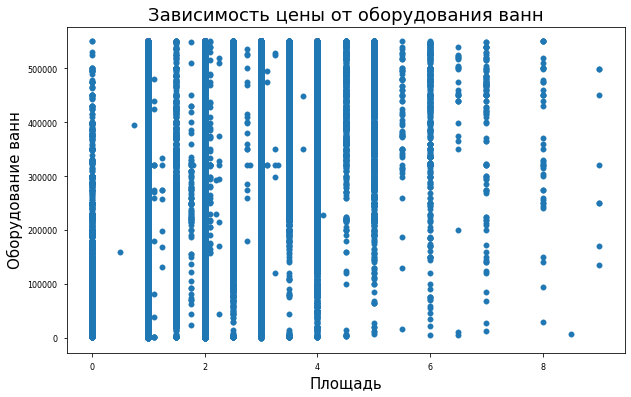

In [295]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Оборудование ванн', fontsize = 15)
plt.title('Зависимость цены от оборудования ванн', fontsize = 18)

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [296]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [297]:
data_d['fireplace'].value_counts() 

yes                                                                32787
Yes                                                                13334
1                                                                  10511
Not Applicable                                                      1952
2                                                                    822
                                                                   ...  
Gas Logs, In Den/Family Room, In Living Room, Wood Burning             1
7                                                                      1
Great Room, Natural Gas, Wood Burning                                  1
Air Filter, Ceiling Fan, Central Vacuum, SMTHR, Walk-In Closets        1
Fireplace-Gas, Fireplace-Wood, Patio, Walk-in Closet                   1
Name: fireplace, Length: 1028, dtype: int64

In [298]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [299]:
data_d['fireplace'].unique()

array([0, 1, 2])

In [300]:
data_d['fireplace'].isna().unique() 

array([False])

In [301]:
x = data_d['fireplace']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от наличия камина')

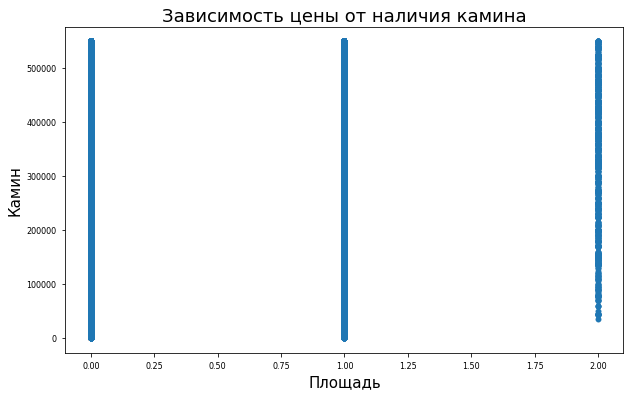

In [302]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Камин', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

# Бассейн. Анализ.

In [303]:
data_d['private pool'].value_counts()

Yes    2729
Name: private pool, dtype: int64

In [304]:
data_d.loc[data_d['private pool'] == 'Yes']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
205,For sale,Yes,Single Family,1403 Betton Rd,2.0,"{'atAGlanceFacts': [{'factValue': '1958', 'fac...",1,Tallahassee,"[{'rating': ['4/10', '5/10', '7/10'], 'data': ...",2361.0,32308,3,FL,NaN,302221,NaN,NaN,385000.0
321,For sale,Yes,Single Family,3296 Ledgewood Cir,3.0,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",0,Riverside,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...",2135.0,92503,3,CA,2.0,IV19242188,NaN,NaN,525000.0
355,For sale,Yes,Mobile / Manufactured,2250 N Broadway # 42,2.0,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",0,Escondido,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...",1536.0,92026,2,CA,0.0,190034991,NaN,NaN,119000.0
425,Pre-foreclosure / auction,Yes,Single Family,7632 Hillside Dr,2.0,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",1,Jacksonville,"[{'rating': ['5/10', '2/10', '4/10'], 'data': ...",1245.0,32221,3,FL,1.0,NaN,NaN,NaN,128103.0
447,For sale,Yes,Single Family,5370 Christie Ann Pl # 17,2.0,"{'atAGlanceFacts': [{'factValue': '1992', 'fac...",0,Sarasota,"[{'rating': ['10/10', '9/10', '6/10'], 'data':...",1936.0,34233,3,FL,1.0,O5821850,NaN,NaN,258000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376298,Pre-foreclosure,Yes,Single Family,15369 Daybreak Ln,3.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",1,Fontana,"[{'rating': ['4/10', '3/10', '4/10'], 'data': ...",2225.0,92337,5,CA,2.0,NaN,NaN,NaN,399094.0
376340,For sale,Yes,Condo,200 River Vista Dr UNIT 436,2.0,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",0,Atlanta,"[{'rating': ['9/10', '6/10', '6/10'], 'data': ...",1299.0,30339,2,GA,1.0,8690633,NaN,NaN,295000.0
376582,For sale,Yes,Single Family,3235 Landover Blvd,2.0,"{'atAGlanceFacts': [{'factValue': '2005', 'fac...",0,Spring Hill,"[{'rating': ['4/10', '6/10'], 'data': {'Distan...",2256.0,34609,4,FL,1.0,2204520,NaN,NaN,225000.0
376686,For sale,Yes,Single Family,2609 S Marigold Ave,3.0,"{'atAGlanceFacts': [{'factValue': '1979', 'fac...",0,Ontario,"[{'rating': ['7/10', '6/10', '5/10'], 'data': ...",1726.0,91761,3,CA,2.0,IV19252050,NaN,NaN,479000.0


Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [305]:
data_d['propertyType'].value_counts(normalize=True)

single-family home                                             0.275224
Single Family                                                  0.183194
Single Family Home                                             0.097924
lot/land                                                       0.068953
condo                                                          0.065922
                                                                 ...   
1 Story, Contemporary, Other (See Remarks)                     0.000004
Traditional, Colonial                                          0.000004
Condo/Townhome, Single Detached                                0.000004
1 Story, Spanish, Ranch, Traditional                           0.000004
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000004
Name: propertyType, Length: 885, dtype: float64

In [306]:
data_d.propertyType = data_d.propertyType.apply(lambda x: str(x))

In [307]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [308]:
data_d['propertyType'].value_counts(normalize=True)

sfh                                                            0.508385
nan                                                            0.086200
lot/land                                                       0.063010
condo                                                          0.060240
Condo                                                          0.041209
                                                                 ...   
Penthouse, Low Rise                                            0.000004
Traditional, Loft with Bedrooms                                0.000004
Condo/Townhome, French, Split Level                            0.000004
Traditional, Colonial, Federal                                 0.000004
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000004
Name: propertyType, Length: 884, dtype: float64

In [309]:
data_d.propertyType = data_d.propertyType.apply(lambda x: x.lower())

In [310]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'mlf' if (x.find('multi')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'ctmp' if (x.find('contempor')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'loft' if (x.find('loft')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'twnh' if (x.find('townhouse')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'condo' if (x.find('condo')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sn_dtch' if (x.find('single detached')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'eng' if (x.find('english')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'other' if x not in ['mlf','ctmp','loft','twnh','condo','sn_dtch','eng'] else x)

In [311]:
data_d['propertyType'].value_counts()

other      215075
condo       34314
twnh        14316
mlf          5906
ctmp         2837
sn_dtch      2261
loft           32
eng            27
Name: propertyType, dtype: int64

Преобразование к численному виду.

In [312]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes

In [313]:
data_d['propertyType_cat'].value_counts()

5    215075
0     34314
7     14316
4      5906
1      2837
6      2261
3        32
2        27
Name: propertyType_cat, dtype: int64

In [314]:
data_d['propertyType'].isna().unique() 

array([False])

In [315]:
x = data_d['propertyType_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от типа собственности')

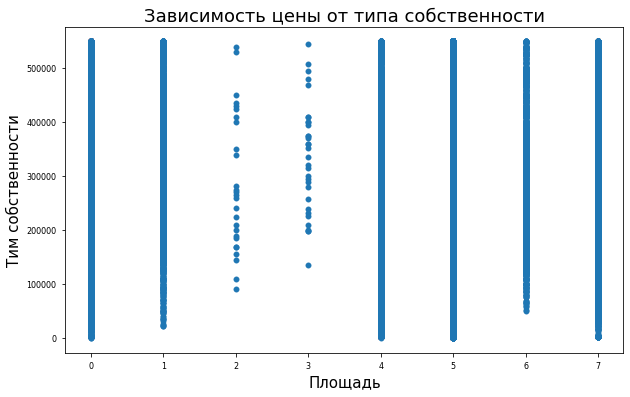

In [316]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Тим собственности', fontsize = 15)
plt.title('Зависимость цены от типа собственности', fontsize = 18)

# Город

In [317]:
data_d.city.fillna('others',inplace=True)

In [318]:
data_d['city'].isna().sum()

0

In [319]:
t = data_d['city'].value_counts()

In [320]:
t

Houston         19033
San Antonio     14423
Miami           10085
Jacksonville     9191
Dallas           5858
                ...  
EVERGREEN           1
Downs               1
Stanwood            1
SUNRISE             1
Blue Springs        1
Name: city, Length: 1806, dtype: int64

In [321]:
t_df = pd.DataFrame(t)

In [322]:
t_df.loc[t_df['city']==np.NaN]

,city


In [323]:
t_df['city'].isna().sum()

0

In [324]:
dict_t = t_df.to_dict()

In [325]:
dict_city = dict_t.get('city')

In [326]:
data_d['city'].isna().sum()

0

Вспомогательная функция присваивает значение others, если число вхождений данного города невелико. (Здесь меньше 500.)

In [327]:
def other_cities(x1,d):
    if x1==np.NaN:
        return ('others')
    elif d.get(x1)==np.NaN:
        return('others')
    elif d.get(x1)<500: return ('others')
    else: return(x1)


In [328]:
data_d.city = data_d.city.apply(lambda x: other_cities(x,dict_city))

In [329]:
data_d.head(30)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat
0,Active,NaN,other,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,others,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.000000,28387,1,NC,NaN,NaN,NaN,611019,418000.0,5
1,for sale,NaN,other,12911 E Heroy Ave,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,others,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.000000,99216,3,WA,2.0,NaN,NaN,201916904,310000.0,5
4,for sale,NaN,other,1524 Kiscoe St,1.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",6594.616652,32908,1,FL,NaN,NaN,NaN,861745,5000.0,5
5,for sale,NaN,twnh,1624 S Newkirk St,1.0,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",0,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897.000000,19145,2,PA,2.0,NaN,NaN,PAPH847006,209000.0,7
6,Active,NaN,other,552 Casanova Ct,1.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",0,others,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...",1507.000000,34759,1,FL,One,NaN,NaN,S5026943,181500.0,5
7,Active,NaN,other,6094 Mingle Dr,1.0,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",0,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",6594.616652,38115,1,TN,NaN,NaN,NaN,10063506,68000.0,5
8,Active,NaN,other,11182 Owl Ave,2.0,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",0,others,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588.000000,50401,1,IA,NaN,NaN,NaN,190988,244900.0,5
9,NaN,NaN,other,8612 Cedar Plains Ln,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...",1930.000000,77080,1,TX,2.0,NaN,NaN,73968331,311995.0,5
11,Active,NaN,eng,4222 False Cypress Ln,1.0,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",0,Houston,"[{'rating': ['6', '3', '6', '1', '5'], 'data':...",3130.000000,77068,1,TX,2,NaN,NaN,5741322,260000.0,2
12,for sale,NaN,other,16373 NW 16th St,3.0,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",0,Pembroke Pines,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...",2839.000000,33028,4,FL,1.0,NaN,yes,A10767242,525000.0,5


In [330]:
data_d.loc[data_d['city']=='others']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat
0,Active,NaN,other,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,others,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.000000,28387,1,NC,NaN,NaN,NaN,611019,418000.0,5
1,for sale,NaN,other,12911 E Heroy Ave,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,others,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.000000,99216,3,WA,2.0,NaN,NaN,201916904,310000.0,5
6,Active,NaN,other,552 Casanova Ct,1.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",0,others,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...",1507.000000,34759,1,FL,One,NaN,NaN,S5026943,181500.0,5
8,Active,NaN,other,11182 Owl Ave,2.0,"{'atAGlanceFacts': [{'factValue': '1970', 'fac...",0,others,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588.000000,50401,1,IA,NaN,NaN,NaN,190988,244900.0,5
13,New construction,NaN,other,1538 Umpqua Dr,2.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,others,"[{'rating': ['7/10', '7/10', '8/10'], 'data': ...",1820.000000,97401,3,OR,1.0,19221142,NaN,NaN,499900.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377140,for sale,NaN,other,6383 Cathedral Dr,1.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,others,"[{'rating': ['5/10', '5/10', '7/10'], 'data': ...",6594.616652,28601,1,NC,NaN,NaN,NaN,3525591,41000.0,5
377147,Active,NaN,other,1022 Lyndon Station Dr,1.0,"{'atAGlanceFacts': [{'factValue': '2020', 'fac...",0,others,"[{'rating': ['8', '4', '7'], 'data': {'Distanc...",2058.000000,28134,1,NC,NaN,NaN,NaN,3576461,342969.0,5
377161,Active,NaN,other,Homestead Dr Lot 1,1.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,others,"[{'rating': ['8', '9', '8', 'NR'], 'data': {'D...",6594.616652,44408,1,OH,NaN,NaN,NaN,3382834,45000.0,5
377173,for sale,NaN,other,19743 N Sagamore Rd,3.0,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",1,others,"[{'rating': ['6/10', '5/10', '6/10'], 'data': ...",2505.000000,44126,5,OH,2.0,NaN,NaN,4126112,384900.0,5


In [331]:
data_d['city'] = data_d['city'].astype('category')
data_d['city_cat'] = data_d['city'].cat.codes

In [332]:
data_d['city_cat'].value_counts()

103    72560
33     19033
85     14423
52     10085
36      9191
       ...  
91       512
34       510
7        506
49       501
68       500
Name: city_cat, Length: 104, dtype: int64

<AxesSubplot:xlabel='city_cat', ylabel='Density'>

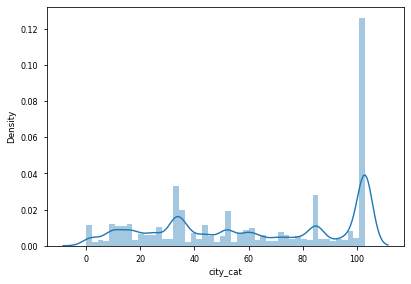

In [333]:
sns.distplot(data_d['city_cat'])

In [334]:
data_d['city_cat'].isna().unique()

array([False])

In [335]:
x = data_d['city_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от города')

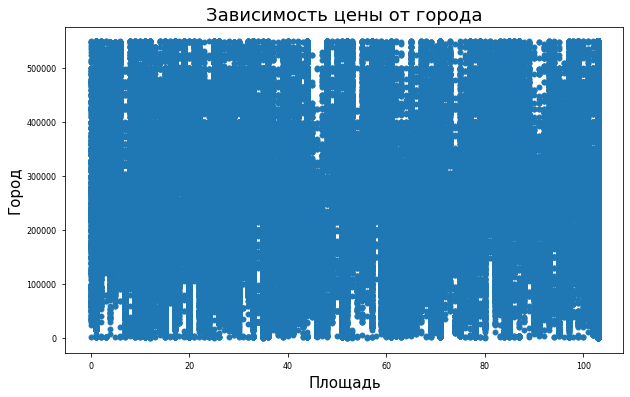

In [336]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Город', fontsize = 15)
plt.title('Зависимость цены от города', fontsize = 18)

# Штат

In [337]:
data_d['state'].value_counts()

FL    90167
TX    68279
NC    17910
TN    15129
OH    11603
CA     8705
WA     7823
NY     7064
IL     6970
NV     6554
GA     5084
MI     4945
PA     4734
CO     4335
AZ     3084
IN     3058
DC     1879
OR     1739
UT      903
MO      807
VT      770
MD      763
MA      552
VA      508
WI      388
NJ      318
ME      251
IA      232
KY       85
OK       49
MS       38
SC       26
MT        7
DE        4
Fl        1
BA        1
AL        1
OT        1
OS        1
Name: state, dtype: int64

In [338]:
data_d['state'] = data_d['state'].astype('category')
data_d['state_cat'] = data_d['state'].cat.codes

In [339]:
data_d['state_cat'].value_counts()

7     90167
33    68279
21    17910
32    15129
25    11603
3      8705
37     7823
24     7064
11     6970
23     6554
9      5084
17     4945
30     4734
4      4335
1      3084
12     3058
5      1879
27     1739
34      903
18      807
36      770
15      763
14      552
35      508
38      388
22      318
16      251
10      232
13       85
26       49
19       38
31       26
20        7
6         4
8         1
2         1
0         1
29        1
28        1
Name: state_cat, dtype: int64

In [340]:
data_d['state_cat'].isna().unique()

array([False])

In [341]:
x = data_d['state_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от штата')

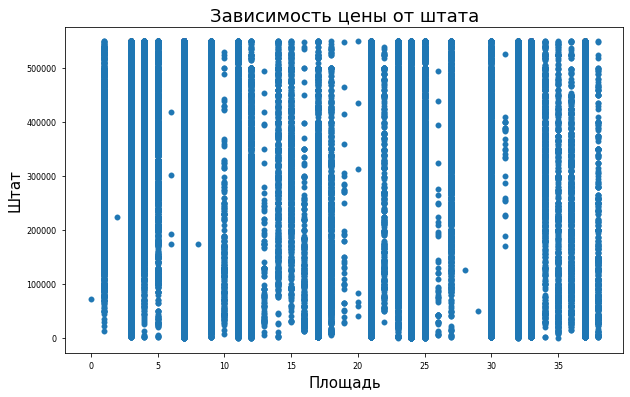

In [342]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Штат', fontsize = 15)
plt.title('Зависимость цены от штата', fontsize = 18)

# Улица

In [343]:
data_d['street'].nunique()

246360

Уникальных значений улиц слишком много. Признак удалила.

 # Stories (надеюсь, это этажи)

In [344]:
data_d['stories'].value_counts()

1.0                         56657
2.0                         38931
1                           19805
2                           12436
3.0                          6145
                            ...  
A Frame                         1
One, Two                        1
42                              1
1-2 Stories, 3-4 Stories        1
Patio Home                      1
Name: stories, Length: 270, dtype: int64

In [345]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num(str(x)))


In [346]:
data_d['stories'].value_counts()

1.00       194934
2.00        55903
3.00         9314
0.00         7763
9.00         2043
4.00         1617
1.50         1144
6.00          520
5.00          460
8.00          218
7.00          190
2.50          142
16.00          48
12.00          36
15.00          36
11.00          33
10.00          29
17.00          28
13.00          25
1.75           25
20.00          24
14.00          22
25.00          21
21.00          20
1.70           17
18.00          16
27.00          14
22.00          13
24.00          12
23.00          12
26.00           9
19.00           8
43.00           8
29.00           8
28.00           5
42.00           4
33.00           4
32.00           4
36.00           4
31.00           3
30.00           3
49.00           3
47.00           3
46.00           2
35.00           2
57.00           2
56.00           2
1.30            2
48.00           2
45.00           1
1.20            1
60.00           1
55.00           1
40.00           1
1120.00         1
41.00     

In [347]:
data_d['stories'].isna().unique()

array([False])

<AxesSubplot:xlabel='stories', ylabel='Density'>

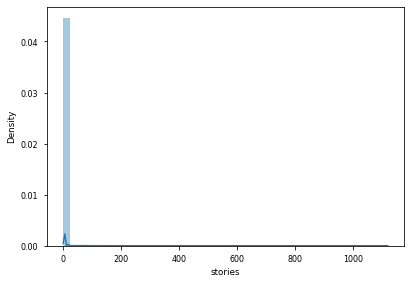

In [348]:
sns.distplot(data_d['stories'])

In [349]:
data_d.loc[data_d['stories']>17].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 612 to 375325
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   status            168 non-null    object  
 1   private pool      2 non-null      object  
 2   propertyType      216 non-null    category
 3   street            216 non-null    object  
 4   baths             216 non-null    float64 
 5   homeFacts         216 non-null    object  
 6   fireplace         216 non-null    int64   
 7   city              216 non-null    category
 8   schools           216 non-null    object  
 9   sqft              216 non-null    float64 
 10  zipcode           216 non-null    object  
 11  beds              216 non-null    int64   
 12  state             216 non-null    category
 13  stories           216 non-null    float64 
 14  mls-id            4 non-null      object  
 15  PrivatePool       90 non-null     object  
 16  MlsId             165

In [350]:
data_d = data_d[data_d['stories']<17]

In [351]:
x = data_d['stories']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от этажа')

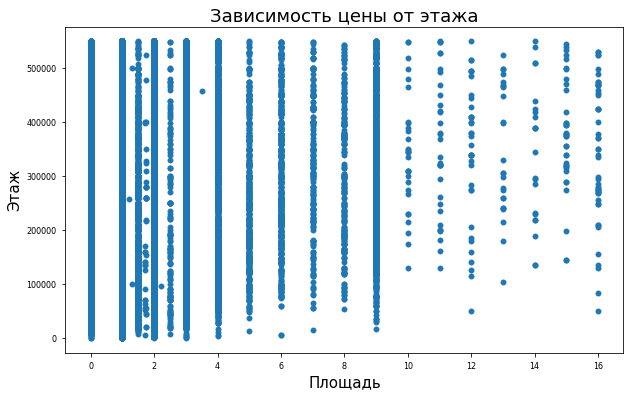

In [352]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Этаж', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

 # Status

In [353]:
data_d['status'].value_counts()

for sale                111749
Active                   76480
For sale                 30151
foreclosure               5866
Pending                   4058
                         ...  
Pending Sale                 1
Coming soon: Nov 30.         1
Coming soon: Dec 16.         1
Coming soon: Dec 18.         1
Accepting backups            1
Name: status, Length: 152, dtype: int64

In [354]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

In [355]:
data_d.status = data_d.status.apply(lambda x: str(x))

In [356]:
data_d.status = data_d.status.apply(lambda x: x.lower())

In [357]:
data_d.status = data_d.status.apply(lambda x: 'actv' if (x.find('activ')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cnstr' if (x.find('construction')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntrct' if (x.find('contract')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'pnd' if (x.find('pending')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntgs' if (x.find('contingen')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cmg_s' if (x.find('coming soon')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)

In [358]:
data_d['status'].unique()

array(['actv', 'for_sale', 'nan', 'cnstr', 'pnd', 'frcls', ' / auction',
       'cntrct', 'p', 'foreclosed', 'for rent', 'auction', 'cntgs',
       'price change', 'back on market', 'new', 'recently sold', 'cmg_s',
       'pf', 'apartment for rent', 'pi', 'due diligence period',
       'c continue show', 'closed', 'for sale', 'c', 'condo for rent',
       'ct', 'accepted offer', 'listing extended',
       'conting accpt backups', 'lease/purchase', 'sold: $285,000',
       'sold: $15,000', 'ps', 'uc continue to show', 'backup',
       'accepting backups'], dtype=object)

In [359]:
data_d['status'].value_counts()

for_sale                 141900
actv                      77306
nan                       30053
frcls                      9457
pnd                        4626
cnstr                      3399
cntrct                     2593
cntgs                       935
p                           781
 / auction                  691
auction                     486
new                         452
foreclosed                  436
price change                406
for rent                    389
recently sold               287
back on market              101
cmg_s                        78
pi                           29
due diligence period         26
c                            18
c continue show              18
closed                       17
listing extended              8
condo for rent                6
apartment for rent            5
accepted offer                4
ct                            3
pf                            3
ps                            2
uc continue to show           2
for sale

Приведение к численному виду.

In [360]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes

In [361]:
data_d['status'].isna().unique()

array([False])

In [362]:
x = data_d['status_cat']
y = data_d['target']


Text(0.5, 1.0, 'Зависимость цены от статуса продажи')

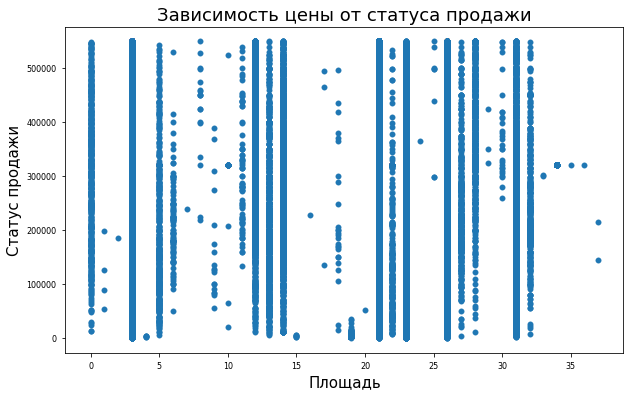

In [363]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Статус продажи', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

# Индекс

In [364]:
data_d['zipcode'].value_counts()

32137         1816
78245         1387
34759         1321
78253         1267
78254         1236
              ... 
78112            1
84044            1
27610-2861       1
27613-4042       1
64015            1
Name: zipcode, Length: 4295, dtype: int64

In [365]:
data_d.zipcode = data_d.zipcode.apply(lambda x: 0 if (x.find('-')>-1) else x)

In [366]:
data_d.zipcode = data_d.zipcode.apply(lambda x: float(x))

In [367]:
data_d['zipcode'].value_counts()

32137.0    1816
78245.0    1387
34759.0    1321
78253.0    1267
78254.0    1236
           ... 
92603.0       1
94086.0       1
41839.0       1
92008.0       1
64015.0       1
Name: zipcode, Length: 4064, dtype: int64

In [368]:
data_d['zipcode'].isna().unique()

array([False])

In [369]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274524 entries, 0 to 377184
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            274524 non-null  category
 1   private pool      2726 non-null    object  
 2   propertyType      274524 non-null  category
 3   street            274523 non-null  object  
 4   baths             274524 non-null  float64 
 5   homeFacts         274524 non-null  object  
 6   fireplace         274524 non-null  int64   
 7   city              274524 non-null  category
 8   schools           274524 non-null  object  
 9   sqft              274524 non-null  float64 
 10  zipcode           274524 non-null  float64 
 11  beds              274524 non-null  int64   
 12  state             274524 non-null  category
 13  stories           274524 non-null  float64 
 14  mls-id            19020 non-null   object  
 15  PrivatePool       22527 non-null   object  
 16  Ml

# Обработка признака homeFacts.

Вспомогательная функция для извлечения списка значимых величин из признака. (Извлекает список словарей из исходной структуры, которая тоже является словарем. Затем по ключевым словам словаря формирует список значимых величин. Возвращает нан, если в списке отсутствует ключевое слово основного словаря.)

In [370]:
def facts_extraction(slovar):
    if slovar.find('atAGlanceFacts')>-1:
        slovar1 = eval(slovar)
       # print(type(slovar1))
        #print(slovar1)
        slovar2=slovar1.get('atAGlanceFacts')
       # print(type(slovar2))
       # print(slovar2)
        
        lst = ['']
        for i in slovar2:
            
            lst.append(i.get('factValue'))
        lst_res=lst[1:]
        return lst_res
            
    else: return np.NaN

In [371]:
data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))

In [372]:
t = data_d['homeFacts']
t

0          [2019, , Central A/C, Heat Pump, , , None, $144]
1                      [2019, , , , , 5828 sqft, $159/sqft]
4                             [, , , , , 10,019 sqft, None]
5         [1920, , Forced Air, Central, , 680 sqft, $233...
6         [2006, 2006, Electric, Heat Pump, Central Air,...
                                ...                        
377177    [1921, , , Central A/C (Electric), Central Hea...
377178    [2019, None, No Data, No Data, 2 spaces, No Da...
377182      [1950, 1950, Other, , 2, 1,600 sqft, $458/sqft]
377183           [None, None, None, None, None, None, None]
377184    [2019, None, Electric, Central, No Data, 6,969...
Name: homeFacts, Length: 274524, dtype: object

In [373]:
t_lst = t.tolist()

In [374]:
columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']

In [375]:
t1 = pd.DataFrame(t_lst, columns = columns)

In [376]:
data_d = data_d.join(t1)

In [377]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat,city_cat,state_cat,status_cat,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.000000,28387.0,1,NC,1.0,NaN,NaN,611019,418000.0,5,103,21,3,2019,,"Central A/C, Heat Pump",,,None,$144
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.000000,99216.0,3,WA,2.0,NaN,NaN,201916904,310000.0,5,103,37,21,2019,,,,,5828 sqft,$159/sqft
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",6594.616652,32908.0,1,FL,1.0,NaN,NaN,861745,5000.0,5,64,7,21,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.


# Обработка признака школы

In [378]:
data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))

In [379]:
t = data_d['schools']
t

0         {'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...
1         {'rating': ['4/10', 'None/10', '4/10'], 'data'...
4         {'rating': ['4/10', '5/10', '5/10'], 'data': {...
5         {'rating': [], 'data': {'Distance': [], 'Grade...
6         {'rating': ['3', '3', '1', 'NR'], 'data': {'Di...
                                ...                        
377177    {'rating': ['4', '6', '5'], 'data': {'Distance...
377178    {'rating': ['7/10', '6/10', '5/10'], 'data': {...
377182    {'rating': ['5/10', '4/10'], 'data': {'Distanc...
377183    {'rating': ['NA', 'NA', 'NA'], 'data': {'Dista...
377184    {'rating': ['5/10', '4/10', '3/10'], 'data': {...
Name: schools, Length: 274524, dtype: object

In [380]:
t_lst = t.tolist()

In [381]:
t5_lst = []
for i in t_lst:
    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
    t5_lst.append(i1)

In [382]:
df_lst = pd.DataFrame(t5_lst,dtype=str)

In [383]:
df_lst.head(10)

,rating,Distance,Grades,name
0,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern..."
1,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval..."
2,"['4/10', '5/10', '5/10']","['5.96mi', '3.25mi', '3.03mi']","['7-8', '9-12', 'PK-6']","['Southwest Middle School', 'Bayside High Scho..."
3,[],[],[],[]
4,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se..."
5,"['4', '2', '2']","['0.7 mi', '0.4 mi', '2.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid..."
6,"['2', '2', '4', '7', '4', 'NR']","['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 ...","['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']","['Roosevelt Elementary School', 'Lincoln Inter..."
7,"['4/10', '3/10', '2/10']","['0.7 mi', '0.6 mi', '1.9 mi']","['PK-5', '5-8', '9-12']","['Edgewood Elementary School', 'Landrum Middle..."
8,"['6', '3', '6', '1', '5']","['0.4 mi', '0.4 mi', '3.0 mi', '3.2 mi', '7.4 ...","['Preschool to 5', '6 to 8', '6 to 8', '9 to 1...","['Pat Reynolds Elementary School', 'Edwin M We..."
9,"['8/10', '7/10', '7/10']","['2.66mi', '0.92mi', '2.54mi']","['6-8', 'PK-5', '9-12']","['Walter C. Young Middle School', 'Silver Palm..."


In [384]:
data_d = data_d.join(df_lst)

In [385]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat,city_cat,state_cat,status_cat,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.000000,28387.0,1,NC,1.0,NaN,NaN,611019,418000.0,5,103,21,3,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern..."
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.000000,99216.0,3,WA,2.0,NaN,NaN,201916904,310000.0,5,103,37,21,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval..."
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",6594.616652,32908.0,1,FL,1.0,NaN,NaN,861745,5000.0,5,64,7,21,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se..."


# Разбор нового признака - рейтинг школы

Вспомогательная функция - возвращает численный список: численное значение рейтинга, если рейтинг выражен числом, первое значение дроби или ноль, если встречаются любые другие символы.

In [404]:
data_d['typeRating']=data_d['rating'].apply(lambda x: type(x))

In [405]:
data_d['typeRating'].value_counts()

<class 'str'>      199644
<class 'float'>     74880
Name: typeRating, dtype: int64

In [409]:
data_d.rating=data_d.rating.apply(lambda x: '[]' if type(x)==float else x)

In [407]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat,city_cat,state_cat,status_cat,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,typeRating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.000000,28387.0,1,NC,1.0,NaN,NaN,611019,418000.0,5,103,21,3,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",<class 'str'>,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.000000,99216.0,3,WA,2.0,NaN,NaN,201916904,310000.0,5,103,37,21,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",<class 'str'>,<class 'str'>
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",6594.616652,32908.0,1,FL,1.0,NaN,NaN,861745,5000.0,5,64,7,21,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","[0.8, 8.3, 4.2, 2.0]","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",<class 'str'>,<class 'str'>
5,for_sale,NaN,twnh,1624 S Newkirk St,1.0,"[1920, , Forced Air, Central, , 680 sqft, $233...",0,Philadelphia,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.000000,19145.0,2,PA,2.0,NaN,NaN,PAPH847006,209000.0,7,71,30,21,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,"['4', '2', '2']","[0.7, 0.4, 2.2]","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid...",<class 'str'>,<class 'str'>


In [410]:
data_d.rating=data_d.rating.apply(lambda x: eval(x))

In [ ]:
data_d.head(4)

In [411]:
def school_rating1 (lst_r):
    lst_clean = []
    for p in lst_r:
        if p.find('/') == -1:
            if p.isdigit():
                lst_clean.append(int(p))
            else: lst_clean.append(0)
        else:
            num = p[:p.find('/')]
            if num.isdigit():
                lst_clean.append(int(num))
                
            else: lst_clean.append(0)

    return lst_clean

In [412]:
data_d.rating = data_d.rating.apply(lambda x: school_rating1(x))

In [413]:
data_d.head(2)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat,city_cat,state_cat,status_cat,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,typeRating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.0,28387.0,1,NC,1.0,NaN,NaN,611019,418000.0,5,103,21,3,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",<class 'str'>,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99216.0,3,WA,2.0,NaN,NaN,201916904,310000.0,5,103,37,21,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",<class 'str'>,<class 'str'>


# Создание новых признаков: маскимальный рейтинг, средний рейтинг.

In [416]:
data_d['max_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else max(x))

In [421]:
data_d['mean_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

In [422]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat,city_cat,state_cat,status_cat,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,typeRating,type_Dist,max_rating,mean_rating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.000000,28387.0,1,NC,1.0,NaN,NaN,611019,418000.0,5,103,21,3,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",<class 'str'>,<class 'str'>,7,3.25
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.000000,99216.0,3,WA,2.0,NaN,NaN,201916904,310000.0,5,103,37,21,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",<class 'str'>,<class 'str'>,4,2.67
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",6594.616652,32908.0,1,FL,1.0,NaN,NaN,861745,5000.0,5,64,7,21,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"[3, 3, 1, 0]","[0.8, 8.3, 4.2, 2.0]","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",<class 'str'>,<class 'str'>,3,1.75


# Разбор нового признака расстояние

Вспомогательная функция возвращает список числовых значений расстояния

In [396]:
data_d.Distance=data_d.Distance.apply(lambda x: '[]' if type(x)==float else x)

In [397]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [398]:
data_d['type_Dist'].value_counts()

<class 'str'>    274524
Name: type_Dist, dtype: int64

In [399]:
data_d.Distance = data_d.Distance.apply(lambda x: eval(x))

In [393]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [394]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat,city_cat,state_cat,status_cat,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,typeRating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.000000,28387.0,1,NC,1.0,NaN,NaN,611019,418000.0,5,103,21,3,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",<class 'str'>,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.000000,99216.0,3,WA,2.0,NaN,NaN,201916904,310000.0,5,103,37,21,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",<class 'str'>,<class 'str'>
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",6594.616652,32908.0,1,FL,1.0,NaN,NaN,861745,5000.0,5,64,7,21,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",<class 'str'>,<class 'str'>
5,for_sale,NaN,twnh,1624 S Newkirk St,1.0,"[1920, , Forced Air, Central, , 680 sqft, $233...",0,Philadelphia,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.000000,19145.0,2,PA,2.0,NaN,NaN,PAPH847006,209000.0,7,71,30,21,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,"['4', '2', '2']","['0.7 mi', '0.4 mi', '2.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid...",<class 'str'>,<class 'str'>


In [395]:
data_d['typeRating'].value_counts()

<class 'str'>      199644
<class 'float'>     74880
Name: typeRating, dtype: int64

In [400]:
def distance_select(distance):
    lst_dist = []
    if distance == []: return []
    else:
        for i in distance:
            if i.find(' mi')>-1:
                lst_dist.append(float(i[:-3]))
            elif i.find('mi')>-1:
                lst_dist.append(float(i[:-2]))
            else: lst_dist.append(0)
    return lst_dist

In [401]:
data_d.Distance = data_d.Distance.apply(lambda x: distance_select(x))

In [402]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat,city_cat,state_cat,status_cat,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,typeRating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.000000,28387.0,1,NC,1.0,NaN,NaN,611019,418000.0,5,103,21,3,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",<class 'str'>,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.000000,99216.0,3,WA,2.0,NaN,NaN,201916904,310000.0,5,103,37,21,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",<class 'str'>,<class 'str'>
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",6594.616652,32908.0,1,FL,1.0,NaN,NaN,861745,5000.0,5,64,7,21,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","[0.8, 8.3, 4.2, 2.0]","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",<class 'str'>,<class 'str'>
5,for_sale,NaN,twnh,1624 S Newkirk St,1.0,"[1920, , Forced Air, Central, , 680 sqft, $233...",0,Philadelphia,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.000000,19145.0,2,PA,2.0,NaN,NaN,PAPH847006,209000.0,7,71,30,21,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,"['4', '2', '2']","[0.7, 0.4, 2.2]","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid...",<class 'str'>,<class 'str'>


# Добавление новых признаков: минимальное расстояние до школы, среднее расстояние до школы.

In [426]:
data_d['min_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else min(x))

In [424]:
data_d['mean_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

In [427]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,propertyType_cat,city_cat,state_cat,status_cat,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,typeRating,type_Dist,max_rating,mean_rating,max_distance,mean_distance,min_distance
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2900.000000,28387.0,1,NC,1.0,NaN,NaN,611019,418000.0,5,103,21,3,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",<class 'str'>,<class 'str'>,7,3.25,12.60,5.54,2.70
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.000000,99216.0,3,WA,2.0,NaN,NaN,201916904,310000.0,5,103,37,21,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",<class 'str'>,<class 'str'>,4,2.67,1.65,1.33,1.01
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",6594.616652,32908.0,1,FL,1.0,NaN,NaN,861745,5000.0,5,64,7,21,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"[3, 3, 1, 0]","[0.8, 8.3, 4.2, 2.0]","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",<class 'str'>,<class 'str'>,3,1.75,8.30,3.83,0.80


# Выбор предварительного датафрейма для модели

In [428]:
data_d_preliminary=data_d[['propertyType_cat','baths','fireplace','sqft','beds','stories','status_cat','city_cat','state_cat','max_rating','mean_rating','min_distance','mean_distance','target']]

In [429]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274524 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   propertyType_cat  274524 non-null  int8   
 1   baths             274524 non-null  float64
 2   fireplace         274524 non-null  int64  
 3   sqft              274524 non-null  float64
 4   beds              274524 non-null  int64  
 5   stories           274524 non-null  float64
 6   status_cat        274524 non-null  int8   
 7   city_cat          274524 non-null  int8   
 8   state_cat         274524 non-null  int8   
 9   max_rating        274524 non-null  int64  
 10  mean_rating       274524 non-null  float64
 11  min_distance      274524 non-null  float64
 12  mean_distance     274524 non-null  float64
 13  target            274524 non-null  float64
dtypes: float64(7), int64(3), int8(4)
memory usage: 32.1 MB


In [ ]:
#data_d_test=data_d[['sqft','target']]

In [ ]:
data_d_preliminary

In [430]:
data_d_preliminary.isna().sum()

propertyType_cat    0
baths               0
fireplace           0
sqft                0
beds                0
stories             0
status_cat          0
city_cat            0
state_cat           0
max_rating          0
mean_rating         0
min_distance        0
mean_distance       0
target              0
dtype: int64

In [ ]:
data_d_preliminary['propertyType_cat'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['baths'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['beds'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['stories'].fillna(method = 'ffill', inplace = True)


In [ ]:
data_d_preliminary.isna().sum()

# Визуализация

In [ ]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [ ]:

#data_d_preliminary['state_cat'] = data_d_preliminary[(data_d_preliminary['state_cat'] < 500 ) | (data_d_preliminary['sity_state_cat'] > 1700)]['sity_state_cat']
#sns.boxplot(data_d_preliminary['sity_state_cat'])

377185

In [ ]:
#data_d_preliminary.isna().sum()

In [ ]:
#values = {'propertyType_cat':1275}
#data_d_preliminary = data_d_preliminary.fillna(value=values)

In [ ]:
#data_d_preliminary = data_d_preliminary.dropna()

In [ ]:
#data_d_preliminary.isnull().sum()

# Нормализация

In [ ]:
# min_maz_Scaler=preprocessing.MinMaxScaler()

In [ ]:
# col=data_d_preliminary.columns
# result=min_maz_Scaler.fit_transform(data_d_preliminary)
# data_d_preliminaty_n=pd.DataFrame(result,columns=col)

In [ ]:
# data_d_preliminaty_n

In [ ]:
#plt.figure(figsize=(18, 10))
#ax = sns.heatmap(data_d_preliminaty_n.corr().abs(), vmin=0, vmax=1, annot = True)
#i, k = ax.get_ylim()
#ax.set_ylim(i+0.5, k-0.5)

> # Грубая модель

In [ ]:
data_d_preliminary

In [ ]:
data_d_preliminary.isna().sum()

In [ ]:
data_d_preliminary['propertyType_cat'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['baths'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['beds'].fillna(method = 'ffill', inplace = True)
data_d_preliminary['stories'].fillna(method = 'ffill', inplace = True)


In [ ]:
data_d_preliminary.isna().sum()

In [ ]:
# data_d_preliminary=data_d_preliminary.dropna()

In [433]:
X=data_d_preliminary[['propertyType_cat','baths','fireplace','sqft','beds','stories','status_cat','city_cat','state_cat','max_rating','mean_rating','min_distance','mean_distance']]

In [434]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274524 entries, 0 to 377184
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   propertyType_cat  274524 non-null  int8   
 1   baths             274524 non-null  float64
 2   fireplace         274524 non-null  int64  
 3   sqft              274524 non-null  float64
 4   beds              274524 non-null  int64  
 5   stories           274524 non-null  float64
 6   status_cat        274524 non-null  int8   
 7   city_cat          274524 non-null  int8   
 8   state_cat         274524 non-null  int8   
 9   max_rating        274524 non-null  int64  
 10  mean_rating       274524 non-null  float64
 11  min_distance      274524 non-null  float64
 12  mean_distance     274524 non-null  float64
dtypes: float64(6), int64(3), int8(4)
memory usage: 30.1 MB


In [435]:
X

,propertyType_cat,baths,fireplace,sqft,beds,stories,status_cat,city_cat,state_cat,max_rating,mean_rating,min_distance,mean_distance
0,5,3.5,0,2900.000000,1,1.0,3,103,21,7,3.25,2.70,5.54
1,5,3.0,0,1947.000000,3,2.0,21,103,37,4,2.67,1.01,1.33
4,5,1.0,0,6594.616652,1,1.0,21,64,7,3,1.75,0.80,3.83
5,7,1.0,0,897.000000,2,2.0,21,71,30,4,2.67,0.40,1.10
6,5,1.0,0,1507.000000,1,1.0,3,103,7,7,3.17,5.60,6.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
377177,6,1.0,0,1895.000000,1,1.0,3,26,33,0,0.00,0.00,0.00
377178,5,2.0,0,1841.000000,1,1.0,26,33,33,0,0.00,0.00,0.00
377182,5,3.0,0,1152.000000,3,2.0,21,103,24,0,0.00,0.00,0.00
377183,5,1.0,0,6594.616652,1,1.0,26,33,33,0,0.00,0.00,0.00


In [ ]:
data_d_preliminary.isna().sum()

In [ ]:
#X_tes = data_d_test[['sqft']]
#y_tes = data_d_test[['target']]

In [ ]:
#X_tes

In [436]:

y = data_d_preliminary[['target']]
y

#X1 = data_d_preliminary[['sity_state_cat','baths','beds']]

,target
0,418000.0
1,310000.0
4,5000.0
5,209000.0
6,181500.0
...,...
377177,199900.0
377178,252990.0
377182,528000.0
377183,34500.0


In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

# Тестирование моделей

# Линейная регрессия

In [438]:
from sklearn import metrics

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

Root Mean Squared Error (RMSE): 122354.79029545849
R2: 0.22


# Случайный лес

In [439]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model =  RandomForestRegressor(n_estimators=10 ,
                               oob_score=True,
                               random_state=RANDOM_SEED)
model.fit(X_train, y_train) # обучение
a = model.predict(X_test) # предсказание
a

score = model.score(X_train, y_train)
print("R-squared:", score) 
#print ("AUC-ROC (oob) = ", roc_auc_score(y_train, model.oob_prediction_))
#print ("AUC-ROC (test) = ", roc_auc_score(y_test, a))

R-squared: 0.9022090498331894


# Регрессия с дополнительными деревьями

In [440]:
extra_tree = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
extra_tree.fit(X_train, y_train)
predict_extra_tree = extra_tree.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)
print(np.array(y_test.index.values))
# оцениваем точность
print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


[ 82881 113914 324012 ... 153931 126373 273255]
7.404331684797752


In [441]:
print(np.array(y_test.index.values))

[ 82881 113914 324012 ... 153931 126373 273255]


In [442]:
print(mape(np.array(y_test.index.values), predict_extra_tree))

7.404331684797752


# Катбуст

In [443]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 117907.8512877	test: 117581.5882583	best: 117581.5882583 (0)	total: 192ms	remaining: 3m 11s
100:	learn: 81999.0686064	test: 86841.1702245	best: 86801.3754166 (97)	total: 6.74s	remaining: 60s
200:	learn: 76980.1511594	test: 87353.9421143	best: 86778.6377121 (106)	total: 13.1s	remaining: 52.2s
300:	learn: 73019.5567883	test: 88056.6309726	best: 86778.6377121 (106)	total: 19.6s	remaining: 45.5s
400:	learn: 69977.5364431	test: 88574.8936009	best: 86778.6377121 (106)	total: 26s	remaining: 38.8s
500:	learn: 67345.2809083	test: 89170.2713688	best: 86778.6377121 (106)	total: 32.9s	remaining: 32.8s
600:	learn: 65046.9394662	test: 89648.9352742	best: 86778.6377121 (106)	total: 39.6s	remaining: 26.3s
700:	learn: 63093.3899206	test: 90100.9672866	best: 86778.6377121 (106)	total: 46.1s	remaining: 19.7s
800:	learn: 61245.1802709	test: 90525.3454930	best: 86778.6377121 (106)	total: 52.6s	remaining: 13.1s
900:	learn: 59618.7675487	test: 90889.6510969	best: 86778.6377121 (106)	total: 59.3s	re

In [445]:
predict_catboost = catboost.predict(X_test)
#predict_catboost_exp=np.exp(predict_catboost)

#predict_catboost_exp

In [446]:
print(f"MAPE: {(mape_log(y_test, predict_catboost))*100:0.2f}%")

ValueError: Unable to coerce to Series, length must be 1: given 90593

In [447]:
predict_catboost 

array([245680.25308492, 204436.97301254,  95872.17558124, ...,
       243484.93139244, 402657.17303708, 122073.55222769])

In [448]:
y_test1=y_test.index.values

In [449]:
y_test1

array([ 82881, 113914, 324012, ..., 153931, 126373, 273255])

In [450]:
print_regression_metrics(y_test1, predict_catboost)

MSE = 27808762866.86, RMSE = 166759.60


In [451]:
print(f"MAPE: {(mape_log(y_test1, predict_catboost))*100:0.2f}%")

MAPE: nan%


In [ ]:
y_pred_exp=np.exp(y_pred)
y_pred_exp

In [452]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 


MSE:  8489662216.345895
RMSE:  4244831108.1729474


In [453]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

{'rating': ['5/10', '4/10', '3/10'],
 'data': {'Distance': ['0.3 mi', '1.1 mi', '4.1 mi'],
  'Grades': ['PK-5', '6-8', '9-12']},
 'name': ['Mary Lou Hartman',
  'Woodlake Hills Middle School',
  'Judson High School']}

# Анализ feature importance

Feature: 0, Score: -4335.73268
Feature: 1, Score: 65539.25057
Feature: 2, Score: 23842.14849
Feature: 3, Score: -9.21751
Feature: 4, Score: -4338.44654
Feature: 5, Score: 6439.06256
Feature: 6, Score: -1781.60591
Feature: 7, Score: 86.76083
Feature: 8, Score: -390.19900
Feature: 9, Score: -93.50474
Feature: 10, Score: 150.40254
Feature: 11, Score: -182.62168
Feature: 12, Score: 230.89215


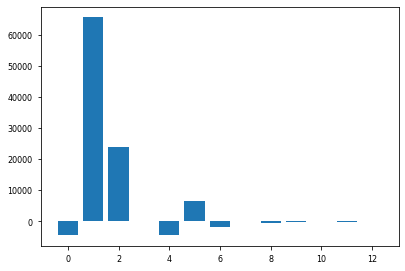

In [454]:
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Text(0.5, 1.0, 'Feature Importance')

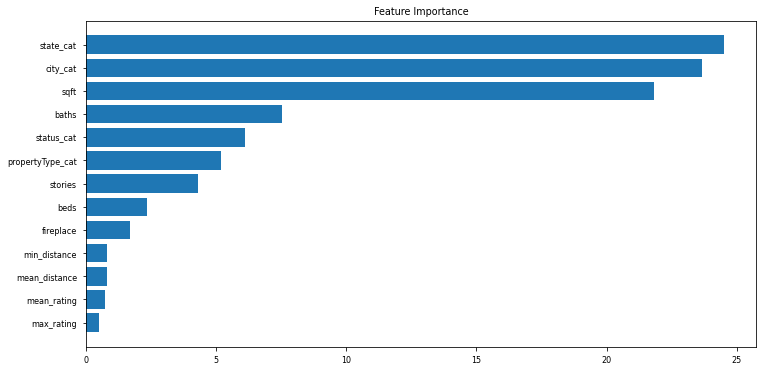

In [455]:
feature_importance=catboost.feature_importances_
sorted_idx=np.argsort(feature_importance)
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align='center')
plt.yticks(range(len(sorted_idx)),np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')